In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import os.path
import shutil
from autopipy.project import Project

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats


In [2]:
%run ../setup_behaviour.py
print(projectName)

autopi_behavior_2021


In [3]:
myProject = Project(name=projectName,dataPath=dataPath)
fn=myProject.dataPath+"/training_sessions"

print("Reading " + fn)
sessionNamesTraining = pd.read_csv(fn) # this will be a pandas dataframe
#sessionNamesTraining
myProject.createSessionList(sessionNameList=sessionNamesTraining.sessionName.to_list(), needVideos=False)
print("We have {} training sessions".format(len(myProject.sessionList)))

Project name: autopi_behavior_2021
dataPath: ~/repo/Jazi_et.al_2023_noInt/data/Jazi_etal_2023_noInter/autopi_behavior_2021
Reading ~/repo/Jazi_et.al_2023_noInt/data/Jazi_etal_2023_noInter/autopi_behavior_2021/training_sessions
We have 151 training sessions


Load the 2df containing the log files from the training sets. 

In [4]:
fn = myProject.dataPath+"/results/logTrainingDF.csv"
log = pd.read_csv(fn)
# save the DataFram as csv file
fn = myProject.dataPath+"/results/protocolTrainingDF.csv"
protocol = pd.read_csv(fn)
print("log length: {}, protocol length: {}".format(len(log),len(protocol)))

log length: 169431, protocol length: 151


## select only the sessions with the lever_training data

In [5]:
leverTrainingSessions = protocol["session"][protocol["script"] == "autopi_lever_training.py"]

In [6]:
logLever = log[log["session"].isin(leverTrainingSessions)]
print("Number of mice : {}".format(logLever["subject"].nunique()))
print("Number of sessions : {}".format(logLever["session"].nunique()))

Number of mice : 20
Number of sessions : 137


Get the rank of each session for each mouse. We want to have a number from 1 to 6 for each session.

In [7]:
logLever["sessionDateTime"] =  pd.to_datetime(logLever["sessionDateTime"]) # somehow needed
logLever["day"] = logLever["sessionDateTime"].groupby(logLever["subject"]).rank(method="dense")
logLever

,Unnamed: 0,event,time,param,timeWS,session,subject,sessionDateTime,day
0,0,start,1.581003e+09,NaN,0.000000,mn3016-06022020-1629,mn3016,2020-02-06 16:29:00,1.0
1,1,magazineBeamBreak,1.581003e+09,NaN,18.744677,mn3016-06022020-1629,mn3016,2020-02-06 16:29:00,1.0
2,2,magazineBeamReceived,1.581003e+09,NaN,18.930677,mn3016-06022020-1629,mn3016,2020-02-06 16:29:00,1.0
3,3,magazineBeamBreak,1.581003e+09,NaN,19.695677,mn3016-06022020-1629,mn3016,2020-02-06 16:29:00,1.0
4,4,magazineBeamReceived,1.581003e+09,NaN,19.879677,mn3016-06022020-1629,mn3016,2020-02-06 16:29:00,1.0
...,...,...,...,...,...,...,...,...,...
169426,1335,magazineBeamBreak,1.590932e+09,NaN,1773.857026,mn633-31052020-1309,mn633,2020-05-31 13:09:00,3.0
169427,1336,magazineBeamReceived,1.590932e+09,NaN,1774.526026,mn633-31052020-1309,mn633,2020-05-31 13:09:00,3.0
169428,1337,magazineBeamBreak,1.590932e+09,NaN,1798.139047,mn633-31052020-1309,mn633,2020-05-31 13:09:00,3.0
169429,1338,magazineBeamReceived,1.590932e+09,NaN,1798.174047,mn633-31052020-1309,mn633,2020-05-31 13:09:00,3.0


## Session summary statistics

Now we want to get summary statistics for each day-mouse combination. 
This will be stored as a new pandas data frame.

We write a function that returns a dataframe with the variables we want per day-mouse, then apply it to a groupby dataframe.

In [8]:
def mySummary(df):
    duration=df["time"].max() - df["time"].min()
    leverPresses=np.sum((df["event"]=="lever_press") |(df["event"]=="leverPress"))
    rewards=np.sum(df["event"]=="pellet_delivery_report")
    leverPressesPerReward = leverPresses/rewards
    rewardRate = rewards/duration*60 # per minutes
    return pd.DataFrame({"duration": [duration],
                        "leverPresses": [leverPresses],
                        "rewards": [rewards],
                        "leverPressesPerReward": [leverPressesPerReward],
                        "rewardRate": [rewardRate]})

sDf = logLever.groupby(["subject","day"]).apply(mySummary).reset_index()

# only keep the first 6 days for the figure
sDf = sDf[sDf.day < 7 ]


In [9]:
sDf

,subject,day,level_2,duration,leverPresses,rewards,leverPressesPerReward,rewardRate
0,mn3016,1.0,0,1802.376751,23,13,1.769231,0.432762
1,mn3016,2.0,0,1802.524856,50,22,2.272727,0.732306
2,mn3016,3.0,0,1802.443332,55,31,1.774194,1.031933
3,mn3016,4.0,0,1802.407652,88,76,1.157895,2.529949
4,mn3016,5.0,0,1026.867459,132,100,1.320000,5.843013
...,...,...,...,...,...,...,...,...
132,mn633,1.0,0,1802.560159,32,22,1.454545,0.732292
133,mn633,2.0,0,1802.510743,35,25,1.400000,0.832173
134,mn633,3.0,0,1802.479396,122,61,2.000000,2.030536
135,mn633,4.0,0,1802.477537,118,76,1.552632,2.529851


In [10]:
print("number of mice: {}".format(sDf["subject"].nunique()))
print("number of sessions: {}".format(len(sDf["subject"])))

number of mice: 20
number of sessions: 117


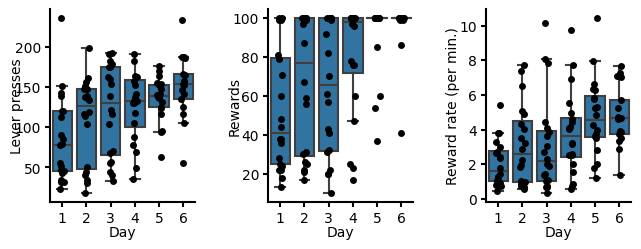

In [11]:
col=3
row=1
sizePerPlot=2.5
fig = plt.figure(figsize=(col*sizePerPlot,row*sizePerPlot))
gs = gridspec.GridSpec(row,col,wspace=0.5, hspace=0.3)
fig.tight_layout()

#############################################
#############################################
##b
ax = plt.subplot(gs[0,0], ) # get a subplot
sns.boxplot(y='leverPresses', x='day', 
                 data=sDf,showfliers=False,color=sns.color_palette()[0] )
sns.stripplot(y='leverPresses', x='day', 
                 data=sDf,color="black")
plt.xticks(range(6),labels=["1","2","3","4","5","6"])
plt.xlabel("Day")
plt.ylabel("Lever presses")
ax.yaxis.set_label_coords(-0.18,0.5)
ax.xaxis.set_label_coords(0.5, -0.12)
ax.tick_params(axis='both', which='major', pad=3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.xaxis.set_tick_params(width=1.5)
ax.yaxis.set_tick_params(width=1.5)


#############################################
# c
ax = plt.subplot(gs[0,1], ) # get a subplot
sns.boxplot(y='rewards', x='day', 
                 data=sDf,showfliers=False,color=sns.color_palette()[0] )
sns.stripplot(y='rewards', x='day', 
                 data=sDf,color="black")
plt.xticks(range(6),labels=["1","2","3","4","5","6"])
plt.xlabel("Day")
plt.ylabel("Rewards")
ax.xaxis.set_label_coords(0.5, -0.12)
ax.yaxis.set_label_coords(-0.18,0.5)
ax.tick_params(axis='both', which='major', pad=3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.xaxis.set_tick_params(width=1.5)
ax.yaxis.set_tick_params(width=1.5)


#############################################
# d
ax = plt.subplot(gs[0,2], ) # get a subplot
sns.boxplot(y='rewardRate', x='day', 
                 data=sDf,showfliers=False,color=sns.color_palette()[0] )
sns.stripplot(y='rewardRate', x='day', 
                 data=sDf,color="black")
plt.xticks(range(6),labels=["1","2","3","4","5","6"])
plt.xlabel("Day")
plt.ylabel("Reward rate (per min.)")
ax.xaxis.set_label_coords(0.5, -0.12)
ax.yaxis.set_label_coords(-0.18,0.5)
ax.tick_params(axis='both', which='major', pad=3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.xaxis.set_tick_params(width=1.5)
ax.yaxis.set_tick_params(width=1.5)


## ExtDataFig2

In [12]:
fn =  myProject.dataPath+"/results/trialsDF.csv"
df = pd.read_csv(fn)


In [13]:
import pickle

fn = myProject.dataPath+"/results/speedProfile.pkl"
print(fn)
sProfile = pickle.load(open(fn, "rb" ) )

if sProfile["searchTotal"].shape[0] != len(df):
    print("Problem with the length of sProfile and df")

~/repo/Jazi_et.al_2023_noInt/data/Jazi_etal_2023_noInter/autopi_behavior_2021/results/speedProfile.pkl


FileNotFoundError: [Errno 2] No such file or directory: '~/repo/Jazi_et.al_2023_noInt/data/Jazi_etal_2023_noInter/autopi_behavior_2021/results/speedProfile.pkl'

Get a first idea of the number of trials we have in our dataset.

In [ ]:
print("Number of mice : {}".format(len(df.subject.unique())))
print("Number of sessions : {}".format(len(df.sessionName.unique())))
print("Number of trials : {}".format(len(df)))
print("Percentage of invalid trials: {:.3} %".format(len(df[df.valid==False])/len(df)*100))
print("Number of dark trials: {}".format(len(df[df.light=="dark"])))
print("Number of light trials: {}".format(len(df[df.light=="light"])))
print("Median number of trials per session: {}".format(df.sessionName.value_counts().median()))
print("Mean number of trials per session: {:.3}".format(df.sessionName.value_counts().mean()))
print("Minimum number of trials per session: {}".format(df.sessionName.value_counts().min()))
print("Maximum number of trials per session: {}".format(df.sessionName.value_counts().max()))

In [ ]:
# to remove trials at the edge
maxDistance=30

df["leverDistanceCenter"] = np.sqrt((df.leverPressX.values**2 + df.leverPressY.values**2))

fig, axes = plt.subplots(1,4,figsize=(10,3))

plt.subplots_adjust(wspace=0.4)
#axes[0].set_aspect('equal', adjustable='box')

axes[0].scatter(df.leverPressX,df.leverPressY,s=3,alpha=0.2)
arena=np.arange(start=0,stop=2*np.pi,step=0.02)
axes[0].plot(np.cos(arena)*40,np.sin(arena)*40,label="arena")
axes[0].plot(np.cos(arena)*maxDistance,np.sin(arena)*maxDistance,label="limit")
axes[0].set_xlabel("cm")
axes[0].set_ylabel("cm")
axes[0].legend(loc="best")
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

axes[1].scatter(df.leverPressX,df.leverPressY,s=3,alpha=0.2)
arena=np.arange(start=0,stop=2*np.pi,step=0.02)
axes[1].plot(np.cos(arena)*40,np.sin(arena)*40,label="arena")
axes[1].plot(np.cos(arena)*30,np.sin(arena)*30,label="limit")
axes[1].set_xlabel("cm")
axes[1].set_ylabel("cm")
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)


axes[2].hist(df.leverDistanceCenter,bins=40)
axes[2].set_xlabel("Lever distance from center (cm)")
axes[2].set_ylabel("Trials")
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)

# clean the dataset from these trials
boolIndices = df.leverDistanceCenter<maxDistance
df = df[boolIndices]

axes[3].hist(df.leverPositionOri, bins=35)
axes[3].set_xlabel('lever orientations (deg)')
axes[3].set_ylabel('Trials')
axes[3].spines['top'].set_visible(False)
axes[3].spines['right'].set_visible(False)
plt.show()